# Embeddings

## What are Embeddings?

For similarity comparisons in Deep Learning: Usage of "Embeddings"

What are they?

"An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models."

For a better understanding let's visualize some embeddings.

### Embeddings Visualization

Popular approach for embedding visualization: T-SNE (t-Distributed Stochastic Neighbor Embedding)

As per SciKitLearn:

- Converts similarities between data points to joint probabilities
- Tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data
- Has a cost function that is not convex, i.e. with different initializations we can get different results
- Highly recommended to use another dimensionality reduction method to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high

Let's use T-SNE to have a look at our original classification embeddings.

Since the original model's architecture was based on manual trial and error, let's use the Keras Tuner to systematically find the best possible model (of similar architecture).

In [1]:
from core.dataset import DGSAlphabet

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_one_hot()

x_train = categorical_dataset.x_train
y_train = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

In [2]:
from core.util import new_SNN_builder

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="classifier",
    loss="categorical_crossentropy",
    metrics=["acc"],
    num_classes=y_test[0].shape[0]
)

In [3]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 150
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42
VAL_SPLIT = 0.2

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "embeddings_classifier"

In [4]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_acc",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Search space summary
Default search space size: 8
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
decoder_dropout (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


In [5]:
from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_acc",
    mode="max",
    lr_reduce_factor=0.2,
    lr_reduce_patience=5,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

In [6]:
tuner.search(
    x_train,
    y_train,
    validation_split=VAL_SPLIT,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

Trial 254 Complete [00h 00m 33s]
val_acc: 0.940119743347168

Best val_acc So Far: 0.957228422164917
Total elapsed time: 02h 42m 55s


In [7]:
tuner.results_summary()

Results summary
Results in tuner/embeddings_classifier
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 0146 summary
Hyperparameters:
dense_count: 6
dense_base: 24
encoder_dropout: False
decoder_dropout: False
start_lr: 0.0005
beta_1: 0.8999999999999999
beta_2: 0.995
epsilon: 0.001
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.957228422164917

Trial 0143 summary
Hyperparameters:
dense_count: 6
dense_base: 24
encoder_dropout: False
decoder_dropout: False
start_lr: 0.0005
beta_1: 0.8999999999999999
beta_2: 0.995
epsilon: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0137
Score: 0.9563729763031006

Trial 0230 summary
Hyperparameters:
dense_count: 6
dense_base: 40
encoder_dropout: False
decoder_dropout: False
start_lr: 0.0006500000000000001
beta_1: 0.7999999999999999
beta_2: 0.995
epsilon: 0.003
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/ro

Since we want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [8]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, snn_classifier = build_model(best_hyper_params, get_encoder=True)
snn_classifier.set_weights(best_weights)

snn_classifier.summary()

Model: "SNN_6_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Input (InputLayer  [(None, 21, 3)]           0         
 )                                                               
                                                                 
 Layer_Norm (LayerNormaliza  (None, 21, 3)             6         
 tion)                                                           
                                                                 
 Flatten_Landmarks (Flatten  (None, 63)                0         
 )                                                               
                                                                 
 Dense_1 (Dense)             (None, 864)               55296     
                                                                 
 Dense_2 (Dense)             (None, 600)               519000    
                                                  

Let's save the best model and take a look at its training history:

In [9]:
from pathlib import Path

MODEL_DIR = "models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

snn_classifier.save(f"{MODEL_DIR}/embeddings_classifier.keras")

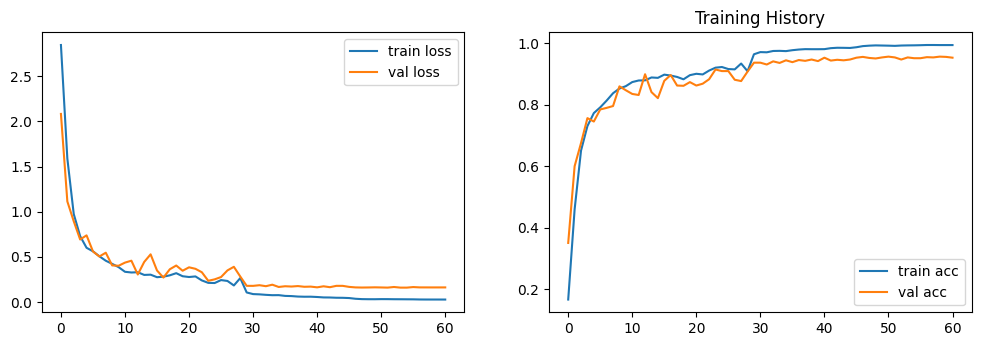

In [10]:
from core.viz import visualize_history

visualize_history(best_model_history, ["loss", "acc"])

Its accuracy is still very close to our original results:

In [11]:
# And evaluate the model on test data
loss, acc = snn_classifier.evaluate(x_test, y_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.1921 acc=0.9542


Now let's visualize the embeddings. For this we'll focus on the model's encoder part (up to "Dense_6"):

In [12]:
# And get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

46/46 [==============================] - 0s 988us/step


Luckily, the weight dimensions are less than 50, so we can use them with T-SNE straight away:

In [13]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1462 samples in 0.000s...
[t-SNE] Computed neighbors for 1462 samples in 0.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1462
[t-SNE] Computed conditional probabilities for sample 1462 / 1462
[t-SNE] Mean sigma: 12.343094
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.812798
[t-SNE] KL divergence after 1000 iterations: 0.376532


If we take a look at our embeddings (which are now reduced to 3 dimensions), we can see how embeddings for different categories are separated in space:

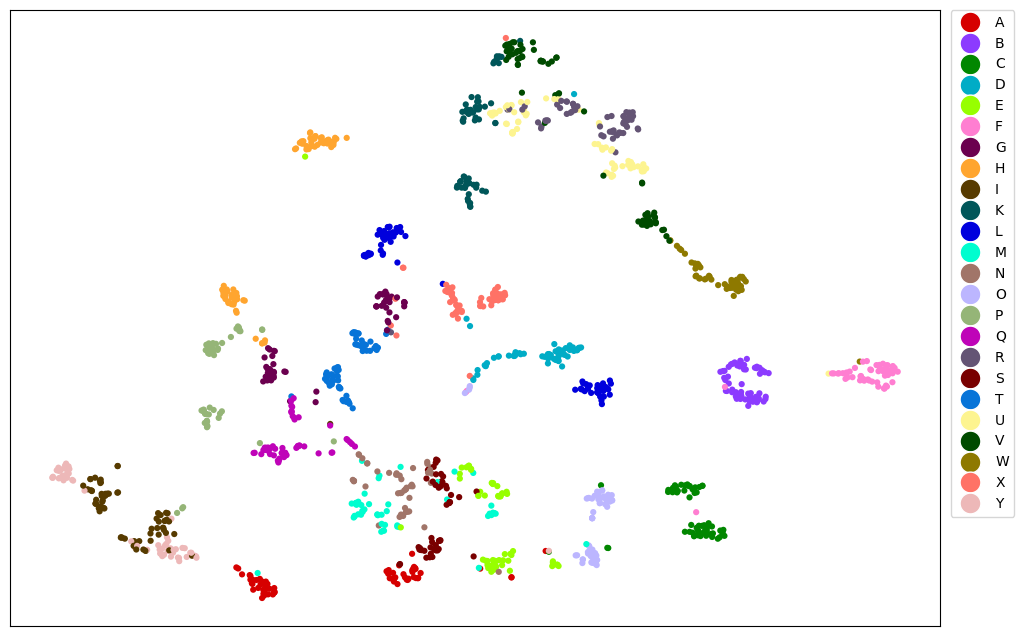

In [14]:
import numpy as np
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
y_test_int_labels = np.argmax(y_test, axis=1)
visualize_embeddings(
    reduced_embeddings,
    y_test_int_labels,
    label_map
)

Let's compare the embeddings' visualization to our model's confusion matrix:

46/46 [==============================] - 0s 2ms/step


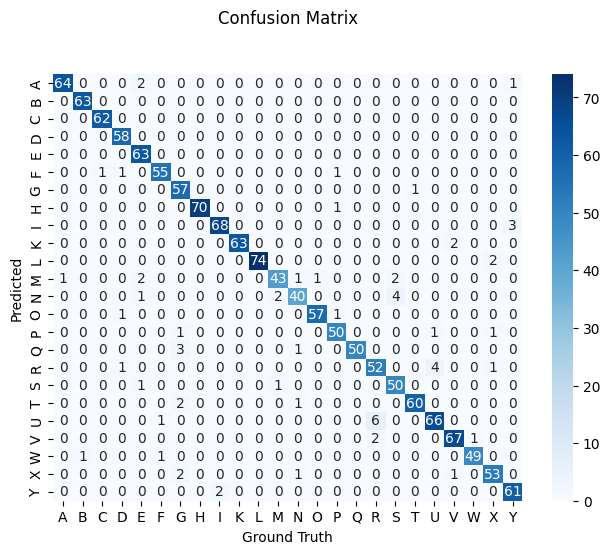

In [15]:
from core.viz import visualize_confusion_matrix


predictions = snn_classifier.predict(x_test)

prediction_classes = np.argmax(predictions, axis=-1)
gt_classes = np.argmax(y_test, axis=-1)
pretty_classes = [lbl.upper() for lbl in label_map.keys()]

visualize_confusion_matrix(gt_classes, prediction_classes, pretty_classes)

We can see that the model most often confuses:

- R with U
- N with M
- Y with I
- U with R
- S with R

This actually corresponds to overlaps in the embeddigs' visualization.